In [1]:
#IMPORTING DEPENDENCIES
import numpy as np
import pandas as pd

#for EDA to detect outliers
import matplotlib.pyplot as plt
plt.style.use(style='ggplot')

#for encoding the categorical variables and scaling the input features
from sklearn.preprocessing import LabelEncoder,MinMaxScaler


# using SMOTE oversampling to deal with the data imbalance 
from collections import Counter
from imblearn.over_sampling import SMOTE


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#using KFold cross validation to reduce overfitting 
from sklearn.model_selection import KFold,StratifiedKFold, cross_val_score

#evaluation metrics 
from sklearn.metrics import f1_score
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
#PART 0- IMPORTING DATA
#reading the test data and the train data
training_dataset = pd.read_csv('Train.csv')
test_dataset = pd.read_csv('Test.csv')
training_dataset.head(5)

,ID,Year_of_Birth,Education_Level,Marital_Status,Disposable_Income,No_of_Kids_in_home,No_of_Teen_in_home,Date_Customer,Recency,Discounted_Purchases,...,Amount_on_SweetProducts,Amount_on_GoldProds,WebVisitsMonth,Cmp3Accepted,Cmp4Accepted,Cmp5Accepted,Cmp1Accepted,Cmp2Accepted,Any_Complain,Response
0,ID_4A9AR6FQ,1955,Graduation,Divorced,77504.4,1,1,22-06-2014,56,2,...,6,20,3,0,0,0,0,0,0,0
1,ID_X28T3VEK,1958,Graduation,Together,56784.0,0,1,01-08-2013,17,6,...,15,19,6,0,0,0,0,0,0,0
2,ID_AWXARH57,1962,Graduation,Single,103714.8,0,0,21-11-2013,17,0,...,18,37,2,0,0,0,1,0,0,1
3,ID_FQVZHE81,1979,2n Cycle,Single,46311.6,1,0,13-09-2013,49,3,...,24,24,8,0,0,0,0,0,0,0
4,ID_QVLWGPRN,1959,Graduation,Married,87486.0,0,0,21-01-2014,59,1,...,165,203,1,0,0,0,1,0,0,0


In [3]:
#PART 1 - EXPLORATORY DATA ANALYSIS 
#visualizing the dataset
#visualising balance
balance=training_dataset.groupby('Response').count()['ID']
balance.head()
# Intuition:Response 1 may be more difficult to learn

Response
0    1329
1     239
Name: ID, dtype: int64

In [4]:
#count of individual classes
Literacy_Level = list(training_dataset['Education_Level'].unique())

Educational_Experience =training_dataset.groupby('Education_Level').count()

viz_dataframe = pd.DataFrame(data=list(Educational_Experience['ID']),index=Literacy_Level,columns =['count'])
viz_dataframe

,count
Graduation,142
2n Cycle,38
Master,802
PhD,246
Basic,340


In [5]:
#description of the columns
training_dataset.shape #to see the size - working in 27-d space 
training_dataset.Response.describe()[:3]#describe the target column - not very useful since discrete 


count    1568.000000
mean        0.152423
std         0.359546
Name: Response, dtype: float64

In [6]:
#extracting numeric_features from columns and showing correlation 
numeric_features = training_dataset.select_dtypes(include=np.number)
#numeric_features.dtypes

#investigating correlation - all attributes are poorly coorelated with the target value
corr = numeric_features.corr()
print(corr['Response'].sort_values(ascending=False)[:4])
print('')
print(corr['Response'].sort_values(ascending=False)[-4:])

Response           1.000000
Cmp5Accepted       0.357647
Cmp1Accepted       0.344083
Amount_on_Wines    0.259173
Name: Response, dtype: float64

WebVisitsMonth       -0.023043
No_of_Kids_in_home   -0.108558
No_of_Teen_in_home   -0.156209
Recency              -0.201654
Name: Response, dtype: float64


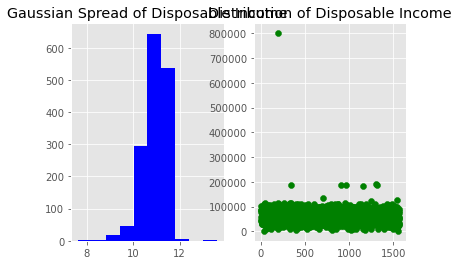

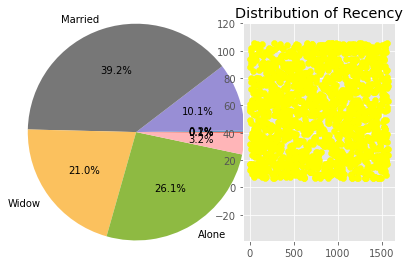

In [7]:
#Visualizing EDA results in a single graph 

plt.subplot(1,2,1)
target=np.log(training_dataset.Disposable_Income)
plt.hist(target,color='blue')
plt.title('Gaussian Spread of Disposable Income')

plt.subplot(1,2,2)
#outlier detection - intuition we discover one outlier at Disposable_Income ='800,000'
#visusalising disposable income 
plt.scatter(np.arange(1568),training_dataset.Disposable_Income,color='green')#f0r bettter intuition 
#plt.ylim(1,150000) #uncomment to exclude outliers 
plt.title('Distribution of Disposable Income')
plt.show()


#division of individual marital classes
Marital_Status_labels = list(training_dataset['Marital_Status'].unique())
Marital_Status_freq =training_dataset.groupby('Marital_Status').count()
plt.subplot(1,2,1)
plt.pie(list(Marital_Status_freq['ID']),labels =Marital_Status_labels,autopct='%1.1f%%',radius = 1.78)


plt.subplot(1,2,2)
#outlier detection 
#visusalising disposable income 
plt.scatter(np.arange(1568),training_dataset.Recency,color='yellow')#for bettter intuition 
plt.ylim(-39,120) #expand for outliers 
plt.title('Distribution of Recency')
plt.show()


In [8]:
#PART 2 - DATA PREPROCESSING
#training and test data transformation 
#encoding categorical variables

df_categorical = training_dataset[['Education_Level', 'Marital_Status']]

#for the test data set 
df_categorical1 = test_dataset[['Education_Level', 'Marital_Status']]

#using the label encoder(OneShotEncoder gives lower performance)
# label encoding 
le = LabelEncoder()
for i in df_categorical:
  training_dataset[i] = le.fit_transform(df_categorical[i])
  test_dataset[i] = le.fit_transform(df_categorical1[i])
training_dataset.head(3) #observe Education_Level and Marital Status transformed


,ID,Year_of_Birth,Education_Level,Marital_Status,Disposable_Income,No_of_Kids_in_home,No_of_Teen_in_home,Date_Customer,Recency,Discounted_Purchases,...,Amount_on_SweetProducts,Amount_on_GoldProds,WebVisitsMonth,Cmp3Accepted,Cmp4Accepted,Cmp5Accepted,Cmp1Accepted,Cmp2Accepted,Any_Complain,Response
0,ID_4A9AR6FQ,1955,2,2,77504.4,1,1,22-06-2014,56,2,...,6,20,3,0,0,0,0,0,0,0
1,ID_X28T3VEK,1958,2,5,56784.0,0,1,01-08-2013,17,6,...,15,19,6,0,0,0,0,0,0,0
2,ID_AWXARH57,1962,2,4,103714.8,0,0,21-11-2013,17,0,...,18,37,2,0,0,0,1,0,0,1


In [9]:
#generating other features led to a more robust model but was not used in this solution 
#extracting date time and year and adding age 
#for training_set

#training_dataset['Day']= pd.to_datetime(training_dataset['Date_Customer']).dt.day
#training_dataset['Month']= pd.to_datetime(training_dataset['Date_Customer']).dt.month
#training_dataset['Year']= pd.to_datetime(training_dataset['Date_Customer']).dt.year

#training_dataset['Age']= training_dataset['Year']-training_dataset['Year_of_Birth']

#for test_set

#test_dataset['Day']= pd.to_datetime(test_dataset['Date_Customer']).dt.day
#test_dataset['Month']= pd.to_datetime(test_dataset['Date_Customer']).dt.month
#test_dataset['Year']= pd.to_datetime(test_dataset['Date_Customer']).dt.year

#test_dataset['Age']= test_dataset['Year']-test_dataset['Year_of_Birth']

#test_dataset.head()

In [10]:
#verifying all is working 
df_new = training_dataset
df_new.head(3)



,ID,Year_of_Birth,Education_Level,Marital_Status,Disposable_Income,No_of_Kids_in_home,No_of_Teen_in_home,Date_Customer,Recency,Discounted_Purchases,...,Amount_on_SweetProducts,Amount_on_GoldProds,WebVisitsMonth,Cmp3Accepted,Cmp4Accepted,Cmp5Accepted,Cmp1Accepted,Cmp2Accepted,Any_Complain,Response
0,ID_4A9AR6FQ,1955,2,2,77504.4,1,1,22-06-2014,56,2,...,6,20,3,0,0,0,0,0,0,0
1,ID_X28T3VEK,1958,2,5,56784.0,0,1,01-08-2013,17,6,...,15,19,6,0,0,0,0,0,0,0
2,ID_AWXARH57,1962,2,4,103714.8,0,0,21-11-2013,17,0,...,18,37,2,0,0,0,1,0,0,1


In [11]:
#missing data - method input using median 

#Dealing with missing values 
#counting missing values i.e NaNs 
nulls = pd.DataFrame(df_new.isnull().sum().sort_values(ascending=False)[:2])
nulls.columns = ['Null Count']
nulls.index.name = 'Feature'
nulls


,Null Count
Feature,
Disposable_Income,16
ID,0


In [12]:
#treat missing values in data(disposable income) by assinging averages 
#data=df_new.select_dtypes(include=[np.number]).interpolate() 

df_new['Disposable_Income'].fillna((df_new['Disposable_Income'].median()) , inplace = True)

df_new.isnull().sum()


ID                         0
Year_of_Birth              0
Education_Level            0
Marital_Status             0
Disposable_Income          0
No_of_Kids_in_home         0
No_of_Teen_in_home         0
Date_Customer              0
Recency                    0
Discounted_Purchases       0
WebPurchases               0
CatalogPurchases           0
StorePurchases             0
Amount_on_Wines            0
Amount_on_Fruits           0
Amount_on_MeatProducts     0
Amount_on_FishProducts     0
Amount_on_SweetProducts    0
Amount_on_GoldProds        0
WebVisitsMonth             0
Cmp3Accepted               0
Cmp4Accepted               0
Cmp5Accepted               0
Cmp1Accepted               0
Cmp2Accepted               0
Any_Complain               0
Response                   0
dtype: int64

In [13]:

#Outlier Removal
df_new = df_new[df_new['Disposable_Income']<300000]

#defining the targes
y= df_new.Response

#dropping irrelevant columns from the training data set 
df_new.drop(columns = ['ID','Date_Customer','Response'],axis=1,inplace=True)

#verifying the shape
df_new.shape

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


(1567, 24)

In [14]:
#for convenience 
X = df_new


In [15]:
#same transformations for TEST DATA
feats = test_dataset
feats
feats.drop(columns = ['ID','Date_Customer'],axis =1,inplace = True)
feats

#missing values 
#treat missing values in data(disposable income) by assinging averages 
feats['Disposable_Income'].fillna((feats['Disposable_Income'].median()) , inplace = True)

feats.isnull().sum()


Year_of_Birth              0
Education_Level            0
Marital_Status             0
Disposable_Income          0
No_of_Kids_in_home         0
No_of_Teen_in_home         0
Recency                    0
Discounted_Purchases       0
WebPurchases               0
CatalogPurchases           0
StorePurchases             0
Amount_on_Wines            0
Amount_on_Fruits           0
Amount_on_MeatProducts     0
Amount_on_FishProducts     0
Amount_on_SweetProducts    0
Amount_on_GoldProds        0
WebVisitsMonth             0
Cmp3Accepted               0
Cmp4Accepted               0
Cmp5Accepted               0
Cmp1Accepted               0
Cmp2Accepted               0
Any_Complain               0
dtype: int64

In [16]:
#Using SMOTE to treat Data Imbalance

In [17]:
#Oversampling 
# summarize class distribution
print("Before oversampling: ",Counter(y))

# define oversampling strategy
sm = SMOTE(sampling_strategy={1:280, 0:1329}, random_state=42, k_neighbors=2, n_jobs=None)

# fit and apply the transform
X_train_SMOTE, y_train_SMOTE = sm.fit_resample(X, y)

# summarize class distribution
print("After oversampling: ",Counter(y_train_SMOTE))


Before oversampling:  Counter({0: 1328, 1: 239})
After oversampling:  Counter({0: 1329, 1: 280})


C:\ProgramData\Anaconda3\lib\site-packages\imblearn\utils\_validation.py:299: UserWarning: After over-sampling, the number of samples (1329) in class 0 will be larger than the number of samples in the majority class (class #0 -> 1328)
  warnings.warn(


In [18]:
#4 BUILDING THE MODEL
#using a random forest classifier with 4-fold cross validation

from lightgbm import LGBMClassifier

In [19]:
%%time
from sklearn.ensemble import RandomForestClassifier
folds = KFold(n_splits=4, shuffle=True, random_state=1234)
oofs = np.zeros((len(X_train_SMOTE)))
preds = np.zeros((len(feats)))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train_SMOTE, y_train_SMOTE)):
    
    X_trn, y_trn = X_train_SMOTE.iloc[trn_idx], y_train_SMOTE.iloc[trn_idx]
    X_val, y_val = X_train_SMOTE.iloc[val_idx], y_train_SMOTE.iloc[val_idx]
    
    
    clf = LGBMClassifier(learning_rate=0.2, n_estimators=1000, scale_pos_weight=4, max_depth=-1, colsample_bytree=0.7, subsample=0.85, reg_alpha=3, reg_lambda=20)
    clf.fit(X_trn, y_trn, eval_set = [(X_val, y_val)],
                    verbose = 0, early_stopping_rounds=200)
    
    vp = clf.predict_proba(X_val)[:,1]
    b = pd.DataFrame(vp)
    b[0] = np.where(b[0]>0.5, 1, 0)
    val_score = f1_score((y_val), (b[0]))
    
    print(f'\nFold {fold_+1} Val score: {val_score}\n')
    
    tp = clf.predict_proba(feats)[:,1]
    
    oofs[val_idx] = vp
    preds += tp/4
    
a = pd.DataFrame(oofs)
a[0] = np.where(a[0]>0.5, 1, 0)
oof_score = f1_score((y_train_SMOTE), (a[0]))
print(f'\nOOF F1 score is : {oof_score}')



Fold 1 Val score: 0.618705035971223


Fold 2 Val score: 0.6394557823129251


Fold 3 Val score: 0.6618705035971223


Fold 4 Val score: 0.5859872611464968


OOF F1 score is : 0.6254295532646047
Wall time: 2.1 s


In [20]:
#5 - SUBMISSION 

In [21]:
#Create submission file using an empty/dummy dataframe
sub_file = pd.DataFrame(columns=['ID', 'Response'])
sub_file.head()

#Save test ID in a copy for creating submission file later
test_dataset = pd.read_csv('Test.csv')
sub_file.ID = test_dataset.ID
sub_file.head()


#Save prediction to submission file created earlier
sub_file.Response = preds
sub_file.head()

#submission 


,ID,Response
0,ID_ZPMABNVX,0.121528
1,ID_WFE91NAA,0.184534
2,ID_JV11RBRK,0.143429
3,ID_6B7SVKY9,0.647884
4,ID_GOVUZ545,0.289208


In [22]:
#interpreting the results to conform to classification limits 
sub_file['Response'] = np.where(sub_file['Response']>=0.5, 1, 0)
sub_file['Response'].value_counts()
#submission
sub_file.to_csv('SampleSubmission.csv',index = False)